## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
---

In [1]:
import os
import cv2
import glob
import time
import pickle
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from moviepy.editor import VideoFileClip
from IPython.display import HTML

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

%matplotlib inline

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

#just a silly wrapper to read images
"""
The training dataset provided for this project ( vehicle and non-vehicle images) are in the .png format. 
Somewhat confusingly, matplotlib image will read these in on a scale of 0 to 1, but cv2.imread() 
will scale them from 0 to 255. Be sure if you are switching between cv2.imread() and matplotlib image 
for reading images that you scale them appropriately! Otherwise your feature vectors can get screwed up.

To add to the confusion, matplotlib image will read .jpg images in on a scale of 0 to 255 so if 
you are testing your pipeline on .jpg images remember to scale them accordingly. 
And if you take an image that is scaled from 0 to 1 and change color spaces using cv2.cvtColor() 
you'll get back an image scaled from 0 to 255. So just be sure to be consistent between 
your training data features and inference features!

Colorspaces: OpenCV uses BGR, matplotlib likes RGB!
"""
def my_readimg(filename, method='xxx'):
    try:
        if method == 'CV2':
            return cv2.imread(filename)
        else:
            return mpimg.imread(filename)
    except:
        print("Oops!", filename)
    
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False,
                       visualise=vis, feature_vector=feature_vec)
    return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, 
                     cspace='BGR2YCrCb', 
                     orient=9, 
                     pix_per_cell=8, 
                     cell_per_block=2,
                     hog_channel = 0,
                     spatial_size=(32, 32),
                     hist_bins=32):
    # Create a list to append feature vectors to
    features = []
    p1 = 0
    p2 = 0
    for file in imgs:
        # Read in each one by one
        image = my_readimg(file)
        if p1==0:
            print(image.dtype)
            p1=1
        #image = image.astype(np.float32)/255
        feature_image = convert_color(image, cspace)
        if p2==0:
            print(image.dtype)
            p2=1
        #feature_image = feature_image.astype(np.float32)/255
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        
        # Call get_hog_features() with vis=False, feature_vec=True
        hog_features = []
        if hog_channel == 'ALL':
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

def store_image(img, img_dir, fname):
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
    img_path = img_dir + fname.split('/')[-1]
    cv2.imwrite(img_path, img)
        

def draw_lines(img, vertices):
    pts= np.int32([vertices])
    cv2.polylines(img, pts, True, (255,0,0),5)

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = my_readimg(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

#read all file names from directories
def read_cars_notcars():
    # Divide up into cars and notcars
    carimages=[]
    ncarimages=[]

    carimages = glob.glob('vehicles/*/*.png')
    ncarimages = glob.glob('non-vehicles/*/*.png')

    cars = []
    notcars = []

    for image in carimages:
        cars.append(image)
    for image in ncarimages:
        notcars.append(image)
    return cars, notcars
    

In [2]:
def train_svc(cars, notcars):
    # Use a linear SVC
    svc = LinearSVC()
    X_scaler = StandardScaler()
    try:
        svc = joblib.load("svc.pkl")
        X_scaler = joblib.load("scaler.pkl")
        print("using trained model")
    except:
        print("building new model")
        ### TODO: Tweak these parameters and see how the results change.
        colorspace = 'BGR2YCrCb'
        orient = 9
        pix_per_cell = 8
        cell_per_block = 2
        hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

        t=time.time()
        car_features = extract_features(cars, cspace=colorspace, orient=orient,
                                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                        hog_channel=hog_channel)
        notcar_features = extract_features(notcars, cspace=colorspace, orient=orient,
                                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                        hog_channel=hog_channel)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to extract HOG features...')
        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)

        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

        print('Using:',orient,'orientations',pix_per_cell,
            'pixels per cell and', cell_per_block,'cells per block')
        print('Feature vector length:', len(X_train[0]))

        # Check the training time for the SVC
        t=time.time()
        svc.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')
        # Check the score of the SVC
        print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
        # Check the prediction time for a single sample
        t=time.time()
        n_predict = 10
        print('My SVC predicts : ', svc.predict(X_test[0:n_predict]))
        print('For these',n_predict, 'lab: ', y_test[0:n_predict])
        t2 = time.time()
        print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

        joblib.dump(svc,"svc.pkl")
        joblib.dump(X_scaler,"scaler.pkl")
    
    return svc, X_scaler
    

# Train classifier

In [3]:
# Divide up into cars and notcars
cars, notcars = read_cars_notcars()
print(data_look(cars, notcars))


{'data_type': dtype('float32'), 'n_cars': 8792, 'image_shape': (64, 64, 3), 'n_notcars': 8968}


In [4]:
svc, scaler = train_svc(cars, notcars)

building new model
float32
float32
float32
float32
83.28 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
10.09 Seconds to train SVC...
Test Accuracy of SVC =  0.993
My SVC predicts :  [ 1.  0.  1.  1.  0.  1.  0.  0.  1.  1.]
For these 10 lab:  [ 1.  0.  1.  1.  0.  1.  0.  0.  1.  1.]
0.00232 Seconds to predict 10 labels with SVC


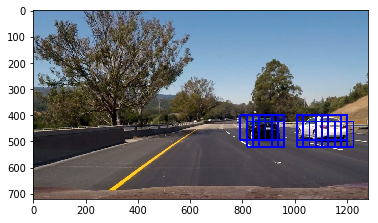

In [11]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):

    draw_img = np.copy(img)
    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='BGR2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            # Create an array stack of feature vectors
            X = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            #X_scaler = StandardScaler().fit(X)
            test_features = X_scaler.transform(X)
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)

    return draw_img

ystart = 400
ystop = 656
scale = 1.5

#X_scaler = StandardScaler()
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32,32)
hist_bins = 32
#scaler = StandardScaler()

img = my_readimg('test_images/test6.jpg')

out_img = find_cars(img, ystart, ystop, scale, svc, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)


## Test pipeline on test images and store output

In [ ]:
# Make a list of calibration images
images = glob.glob('test_images/*.jpg')

def preprocess_img(img):
    undist_img = undistort(img)
    transformed = warp(undist_img)
    binary_image = pipeline(transformed)
    return binary_image

# process test images
for fname in images:
    img = cv2.imread(fname)
    undist_img = undistort(img)
    store_image(undist_img, 'output_images/undistorted/', fname)
    binary_image = pipeline(undist_img)
    store_image(binary_image*255, 'output_images/binary_images/', fname)
    transformed = warp(binary_image)
    store_image(transformed*255, 'output_images/transformed_images/', fname)

plt.figure(figsize=(12, 7))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(2, 2, 2)
plt.imshow(undist_img)
plt.title("Undistorted Image")
plt.subplot(2, 2, 3)
plt.imshow(binary_image*255)
plt.title("Binary Image")
plt.subplot(2, 2, 4)
plt.imshow(transformed*255)
plt.title("Transformed Image")

In [ ]:
def detect_start(binary_warped, LL, RL, fname=None):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #plot
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    LL.update_params(left_fit, right_fit, leftx, lefty, ploty)
    RL.update_params(right_fit, left_fit, rightx, righty, ploty)
    
    if(fname!=None):
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.savefig(fname)

#next frame fit poly
def detect_next(binary_warped, LL, RL):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (LL.current_fit[0]*(nonzeroy**2) + LL.current_fit[1]*nonzeroy + LL.current_fit[2] - margin)) & (nonzerox < (LL.current_fit[0]*(nonzeroy**2) + LL.current_fit[1]*nonzeroy + LL.current_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (RL.current_fit[0]*(nonzeroy**2) + RL.current_fit[1]*nonzeroy + RL.current_fit[2] - margin)) & (nonzerox < (RL.current_fit[0]*(nonzeroy**2) + RL.current_fit[1]*nonzeroy + RL.current_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    LL.update_params(left_fit, right_fit, leftx, lefty, ploty)
    RL.update_params(right_fit, left_fit, rightx, righty, ploty)
        

def calculate_curverad(leftx, rightx, ploty):
    # Define conversions in x and y from pixels space to meters
    y_eval = np.max(ploty)
    #print(y_eval)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print('left:', left_curverad, 'm', 'right:', right_curverad, 'm')
    return left_curverad, right_curverad

def calculate_position(pts_left, pts_right):
    # 10th value for x 
    lane_middle = int((pts_right[0][10][0] - pts_left[0][10][0])/2.)+pts_left[0][10][0]
    #lane_middle = int((pts_right[10] - pts_left[10])/2.)+pts_left[10]
    
    if (lane_middle-640 > 0):
        leng = 3.66/2
        mag = ((lane_middle-640)/640.*leng)
        #head = ("Right",mag)
        return "Right", mag
    else:
        leng = 3.66/2.
        mag = ((lane_middle-640)/640.*leng)*-1
        #head = ("Left",mag)
        return "Left", mag
    
def line_base_pos(current_fit, ploty):
    y_eval = np.max(ploty)
    center_pos = 640
    line_pos = current_fit[0]*y_eval**2 + current_fit[1]*y_eval + current_fit[2]
    line_base_pos = (line_pos - center_pos)*3.7/600.0 #3.7 meters is about 600 pixels in the x direction
    
    # avoid negative distances, which would be the case for left lane
    # there is sure an more elegant way to handle this
    if line_base_pos < 0:
        line_base_pos *= (-1.0)
        
    return line_base_pos

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, name='ABC'):
        #Line name
        self.line_name = name
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #store detection miss here
        self.detection_miss = 0
        #rejection counter
        self.reject_counter = 0
    
    #check against big radius number doesn't make sense 
    #since in case of straight line it becomes very big
    #mr - my radius, otr - other radius
    def radius_in_range(self, mr, otr):
        result = False
        #radius check, reject too small radius
        if mr > 100: #200
            #check difference btw. two radius
            rd = np.abs(mr-otr)
            if rd < 60000:
                result = True
            else:
                print('Radius difference ', rd, ' not plauible -> reject line')
        else:
            print('Radius ', (mr), ' not plauible -> reject line')
        
        return result
    
    #mp - my position, otp - other position
    def position_in_range(self, mp, otp):
        result = False
        lane_width = 3.7    #in m
        max_tolerance = 0.7 # +/- tolerance in m
        #check lane width
        if (mp + otp) < lane_width + max_tolerance and (mp + otp) > lane_width - max_tolerance:
            
            result = (mp > ((lane_width / 2) - max_tolerance) and \
                     mp < ((lane_width / 2) + max_tolerance))
            
            if result == False:
                print('Line tolerance check for ', (mp), ' failed -> reject line')
        else:
            print('Lane width ', (mp+otp), ' not plauible -> reject line')
        return result
    
    #use both fits to have more sanity checks possibilities
    def update_params(self, my_fit, other_fit, allx, ally, ploty):
        # sanity check of the incoming params
        my_fitx = my_fit[0]*ploty**2 + my_fit[1]*ploty + my_fit[2]
        other_fitx = other_fit[0]*ploty**2 + other_fit[1]*ploty + other_fit[2]
        
        mr, otr = calculate_curverad(my_fitx, other_fitx, ploty)
        mp = line_base_pos (my_fit, ploty)
        otp = line_base_pos (other_fit, ploty)
        
        if self.radius_in_range(mr, otr) and self.position_in_range(mp, otp):
            self.detection_miss = 0
            self.detected = True
            self.recent_xfitted = my_fitx
            self.current_fit = my_fit
            self.radius_of_curvature = mr
            self.line_base_pos = mp
            self.allx = allx
            self.ally = ally
        else: # in case a miss increase the counter
            self.detection_miss +=1
            self.reject_counter +=1
            print(self.detection_miss, ' detections missed')
            if self.detection_miss >= 2:
                print(self.detection_miss, ' detections missed -> new detection cycle')
                self.detection_miss=0
                self.detected = False
                

In [ ]:
# draw final lane on the original undistorted image
# add radius and distance information to every image
def draw_lane(undist, warped, LL, RL, fname=None):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([LL.recent_xfitted, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([RL.recent_xfitted, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warp(color_warp, False) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    #put radius and distance info on image
    color = (255,255,255)
    font = cv2.FONT_HERSHEY_SIMPLEX
        
    pos_rad_text = (50,50)
    pos_dis_text = (50,150)
    
    #Calcuate lane radius as a mean of both lines
    l = round(LL.radius_of_curvature, 2)
    r = round(RL.radius_of_curvature, 2)
    medianr = round((l+r)/2, 2)
    
    #Calcuate vehicle position
    posstr, pos = calculate_position(pts_left, pts_right)
    
    mrad = str('Lane curvature: ' + str(medianr) + 'm')
    offc = str('Vehicle is ' + str(round(pos,2)) + 'm' + ' ' + posstr + ' ' + 'of center')
    
    cv2.putText(result, mrad, pos_rad_text, font, 2, color, 2, cv2.LINE_AA)
    cv2.putText(result, offc, pos_dis_text, font, 2, color, 2, cv2.LINE_AA)
    
    if fname!=None:
        plt.savefig(fname)
    
    return result

In [ ]:
# process test images
#for fname in images:
L = Line('Left')
R = Line('Right')

img = cv2.imread('test_images/test6.jpg')

undist = undistort(img)
prep_img = preprocess_img(img)
detect_start(prep_img, L, R, 'output_images/left_fitx_right_fitx.jpg')

#print ('L ', L.recent_xfitted)
#print ('R ', R.recent_xfitted)

result = draw_lane(undist, prep_img, L,  R)
plt.imshow(result)
plt.savefig('output_images/test4_final_lane.jpg')

In [ ]:
img2 = cv2.imread('test_images/straight_lines1.jpg')

shape = img2.shape

src = np.float32([[585, 460],[203, 720],[1127, 720],[695, 460]])
dst = np.float32([[320, 0],[320, 720],[960, 720],[960, 0]])

undist2 = undistort(img2)
warp2 = warp(undist2)

draw_lines(warp2, dst)
draw_lines(img2, src)

plt.figure(figsize=(12, 7))
plt.subplot(2, 2, 1)
plt.imshow(img2)
plt.title("Original image with source points")
plt.subplot(2, 2, 2)
plt.imshow(warp2)
plt.title("Undistorted warped image")

plt.savefig('output_images/warped_undistorted.jpg')

In [ ]:
def process_image(img):
    global LLine
    global RLine
    undist = undistort(img)
    prep_img = preprocess_img(img)
    if LLine.detected == False or RLine.detected == False:
        print('LL: ', LLine.detected, 'RL: ', RLine.detected, '-> start new detection cycle')
        detect_start(prep_img, LLine, RLine)
    else:
        detect_next(prep_img, LLine, RLine)
    result = draw_lane(undist, prep_img, LLine,  RLine)
    return result

In [ ]:
LLine = Line('L')
RLine = Line('R')

out_dir='./'
output = out_dir + 'processed_project_video.mp4'
clip = VideoFileClip('project_video.mp4')
out_clip = clip.fl_image(process_image) 
%time out_clip.write_videofile(output, audio=False)
print(LLine.reject_counter, ' rejections for ', LLine.line_name)
print(RLine.reject_counter, ' rejections for ', RLine.line_name)